In [1]:
import six
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import math_ops
from deeplab import common
from deeplab import model
from deeplab.datasets import data_generator
from deeplab.utils import train_utils
import os
from deeplab.utils import get_dataset_colormap
from seg_exp import seg_encoder, seg_decoder
from bls2017_comp_seg import build_model
import numpy as np


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
tf.logging.set_verbosity(tf.logging.INFO)

dataset = data_generator.Dataset(
      dataset_name='cityscapes',
      split_name='val',
      dataset_dir='/datatmp/Experiments/belbarashy/datasets/Cityscapes/tfrecord/',
      batch_size=1,
      crop_size=[int(sz) for sz in [1024,2048]],
      min_resize_value=None,
      max_resize_value=None,
      resize_factor=None,
      model_variant=None,
      num_readers=2,
      is_training=False,
      should_shuffle=False,
      should_repeat=False)

samples = dataset.get_one_shot_iterator().get_next()
in_imgs = samples['image']/255
depth   = samples['depth'] /255
labels  = samples['label']  # channel=1
num_classes = dataset.num_of_classes
"""
use_skip = True
use_skip_1by1 = True
latents, skip = seg_encoder('Encoder', in_imgs, training=False)

if use_skip_1by1:
    skip = tf.layers.conv2d(inputs=skip,filters=32,kernel_size=[1,1],strides = (1,1),use_bias = False,padding="same")
if not use_skip:
    skip = None

logits = seg_decoder('Decoder', latents, training=False, num_classes=num_classes, skip=skip)
"""
_, eval_bpp, _, x_hat, y_hat, y, string, _, seg_logits, seg_loss = \
build_model(in_imgs, depth, None, num_classes, mode='testing')


if seg_logits is not None:
    predictions = tf.argmax(seg_logits, 3) # batch*H*W*1
else:
    predictions = x_hat
#predictions = tf.reshape(predictions, shape=[-1])
#labels = tf.reshape(labels, shape=[-1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.


/datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/model.ckpt-200000
INFO:tensorflow:Restoring parameters from /datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/model.ckpt-200000
(1, 1024, 2048, 1)
(1, 1024, 2048)
(1024, 2048)
(1024, 2048)


(-0.5, 2047.5, 1023.5, -0.5)

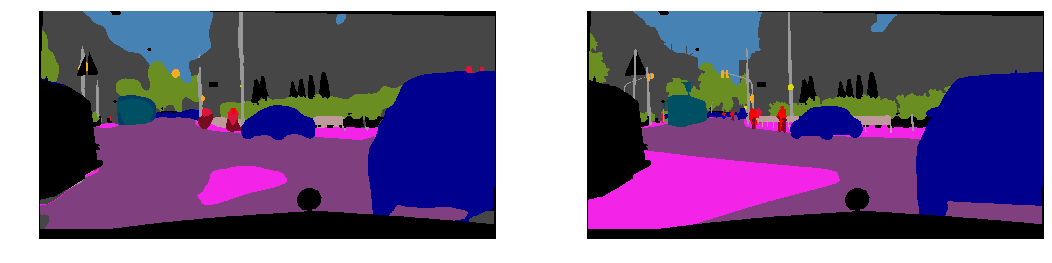

In [4]:
with tf.Session() as sess:
    #latest = tf.train.latest_checkpoint(checkpoint_dir='../experiments/exp_seg_wo_skip/')
    #latest = tf.train.latest_checkpoint(checkpoint_dir='../experiments/exp_seg_w_skip1by1_fixedlr/')
    latest = tf.train.latest_checkpoint(checkpoint_dir='/datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/')
    print(latest)
    tf.train.Saver().restore(sess, save_path=latest)    
    for i in range(5): #17
        p,l, lats, input_img, dep = sess.run([predictions, labels, y, in_imgs, depth])
    
    #l = tf.reshape(l, shape=[-1])
    #l = tf.one_hot(l, num_classes, on_value=1.0, off_value=0.0)
    #print(one_hot_labels.shape)
input_img = np.squeeze(input_img)
print(l.shape)
l = np.squeeze(l)
print(p.shape)
p = np.squeeze(p)
print(l.shape)
print(p.shape)
if False:#p.shape[2] == 3:
    colored_pred  = p
    colored_label = input_img
else:
    p[l==255] = 255
    colored_pred  = get_dataset_colormap.label_to_color_image(p, 'cityscapes')
    colored_label = get_dataset_colormap.label_to_color_image(l, 'cityscapes')

    
plt.figure(figsize=(18, 18))
plt.subplot(221)
plt.imshow( colored_pred )
plt.axis('off')
plt.subplot(222)#
plt.imshow( colored_label)
plt.axis('off')

(1024, 2048)


(-0.5, 2047.5, 1023.5, -0.5)

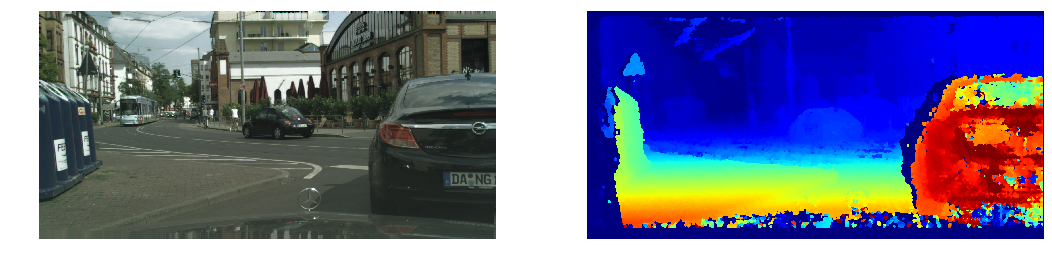

In [5]:
dep = np.squeeze(dep)
print(dep.shape)
plt.figure(figsize=(18, 18))
plt.subplot(221)
plt.imshow( input_img )
plt.axis('off')
plt.subplot(222)#
plt.imshow( dep, cmap='jet')
plt.axis('off')

(-0.5, 2047.5, 1023.5, -0.5)

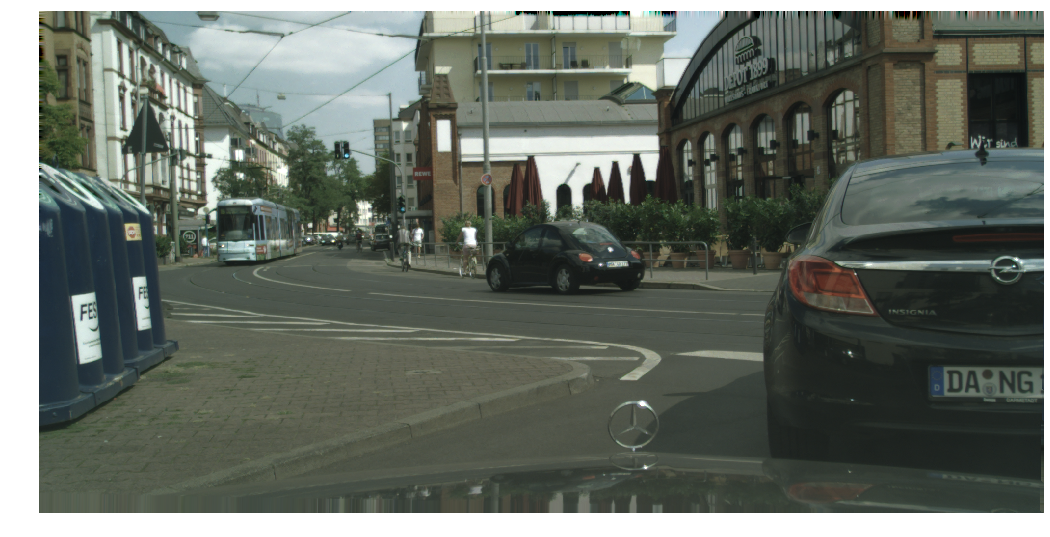

In [6]:
plt.figure(figsize=(18, 18))
plt.imshow( input_img )
plt.axis('off')

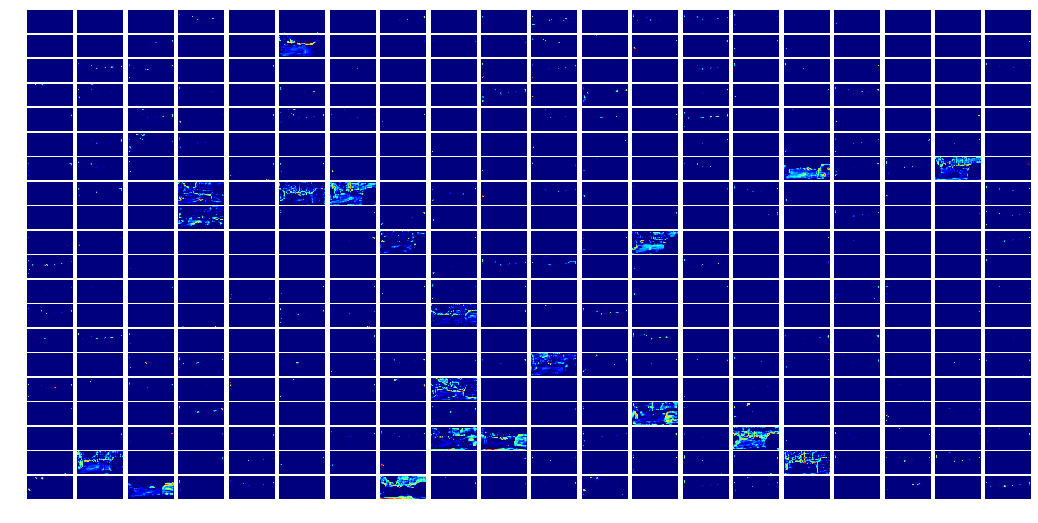

In [8]:
import cv2
#100 feats maps from 512
#resized_input = cv2.resize(input_img,(int(input_img.shape[1]/16),int(input_img.shape[0]/16)))
fig = plt.figure(figsize=(18, 9))
nrows = ncols = 20
for i in range(nrows*ncols):
    f = lats[0,:,:,i]
    #masked = resized_input.copy()
    #masked[:,:,0] = resized_input[:,:,0] * f
    #masked[:,:,1] = resized_input[:,:,1] * f
    #masked[:,:,2] = resized_input[:,:,2] * f
    plt.subplot(nrows, ncols, i+1)
    #plt.imshow(masked/(100))
    plt.imshow( f ,cmap='jet')
    plt.axis('off')
    fig.subplots_adjust(hspace=.05, wspace=.1)